### 分析非法网站和合法网站的ns的数量

* 合法域名和非法域名使用ns的数量
* **注意**：这个数据只解析一次域名的IP地址的数据
* todo  
    * 是否需要进行多次探测，发现其ns是否有变化

In [208]:
# encoding:utf-8
from collections import Counter
from pymongo import MongoClient
from pandas import Series

% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tldextract

In [220]:
client = MongoClient('172.29.152.152', 27017)
db = client['eds_last']
domain_col = db['domain_ttl_white_china']
mal_col = db['domain_ttl_new']

In [221]:
def is_same(ns_list):
    """
    判断NS记录集合是否相同的二级域名
    """
    domain_set = set()
    for i in ns_list:
        domain_tld = tldextract.extract(i.lower())
        domain_set.add(domain_tld.domain+'.'+domain_tld.suffix)
    return len(domain_set)==1

In [222]:
def classify_ns(records):
    """
    分类NS，分为相同NS域名和不同NS域名
    """
    same_name = []
    not_same_name = []
    for r in records:
        ns_list = r['data'][0]['ns']
        if is_same(ns_list):
            same_name.append(ns_list)
        else:
            not_same_name.append(ns_list)
    return same_name,not_same_name          

In [223]:
def count_ns(ns_name):
    """
    计数不同NS数量的域名数量
    """
    ns_counter = Counter()
    for i in ns_name:
        ns_counter[len(i)]+=1
    return ns_counter

In [224]:

def union_ns(dm_counter, mal_counter):
    """
    合并两类NS"""
    index = list(set(dm_counter.keys()+mal_counter.keys()))
    
    mal_series = Series(mal_counter, index = index)
    dm_series = Series(dm_counter,index = index)
    mal_series = mal_series.fillna(0)
    dm_series = dm_series.fillna(0)
    mal_series = mal_series/mal_series.sum()
    dm_series = dm_series/dm_series.sum()
    return mal_series, dm_series

In [225]:
def count_same_ns(ns_list):
    ns_counter = Counter()
    for i in ns_list:
        domain_tld = tldextract.extract(i[0].lower())
        ns_counter[domain_tld.domain+'.'+domain_tld.suffix]+=1
#     for i,j in ns_counter.most_common():
#         print i,j
    return ns_counter

In [226]:
domain_records = domain_col.find({'data.ns':{'$not': {'$size': 0}}})
mal_records = mal_col.find({'data.ns':{'$not': {'$size': 0}}})

dm_same_name,dm_not_same_name = classify_ns(domain_records)
mal_same_name,mal_not_same_name = classify_ns(mal_records)

dm_total_ns =  domain_records.count()
dm_total_not_ns = len(dm_not_same_name)
mal_total_ns = mal_records.count()
mal_total_not_ns = len(mal_not_same_name)

print dm_total_ns,dm_total_not_ns, float(dm_total_not_ns)/dm_total_ns
print mal_total_ns,mal_total_not_ns, float(mal_total_not_ns)/mal_total_ns

dm_counter = count_ns(dm_not_same_name)
mal_counter = count_ns(mal_not_same_name)

mal_series, dm_series = union_ns(dm_counter,mal_counter)

dm_same_cnt = count_same_ns(dm_same_name)
mal_same_cnt = count_same_ns(mal_same_name)

21911 2732 0.12468623066
40894 3621 0.0885459969678


* 上面数据说明  
    * 白名单的NS服务器更加不一致，防止出现问题
    * 非法域名则大部分相同，可能未考虑这方面的内容

## 含有不同NS记录的域名进行分析

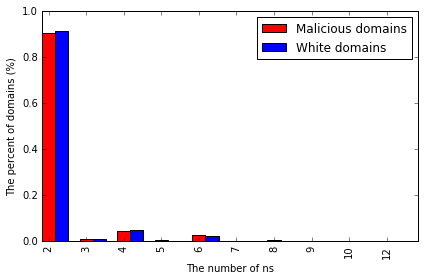

In [227]:
fig, ax = plt.subplots(figsize=(6, 4))
index = np.arange(mal_series.size)
bar_width = 0.35

rects1 = ax.bar(index, mal_series.values, bar_width, color='r', label='Malicious domains')
rects2 = ax.bar(index + bar_width, dm_series.values, bar_width, color='b', label='White domains')

ax.set_xlabel('The number of ns')
ax.set_ylabel('The percent of domains (%)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mal_series.index,rotation=90)
ax.legend()
fig.tight_layout()
plt.show()

上图说明：
*  非法域名大部分为2个NS服务器
* 合法域名不同的NS服务器情况，多存在于含有4个NS记录的域名中

In [231]:
for i,j in mal_same_cnt.most_common(20):
    print i,'\t',j

dnspod.net 	10432
iidns.com 	5129
domaincontrol.com 	3118
dnspod.com 	2588
hichina.com 	2296
dns.com 	1208
dns123456789.com 	850
name-services.com 	801
22.cn 	659
51dns.com 	539
cloudflare.com 	508
ecedns.com 	442
xundns.com 	418
myhostadmin.net 	397
qndns.com 	347
xincache.com 	342
alidns.com 	310
dnsv2.com 	286
0123401234.com 	257
dnsever.com 	235
